# Практическая работа 4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from itertools import combinations
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Задание 1
Определить два вектора, представляющие собой число автомобилей, припаркованных в течении 5 рабочих дней у бизнес-центра на уличной стоянке и в подземном гараже.

In [2]:
x = np.array([80, 98, 75, 91, 78])
y = np.array([100, 82, 105, 89, 102])

### Заданние 1.1
Найти и интерпретировать корреляцию между переменными «Улица» и «Гараж» (подсчитать корреляцию по Пирсону).


In [3]:
np.corrcoef(x, y)[0, 1]

-0.9999999999999998

### Задание 1.2
Построить диаграмму рассеяния для вышеупомянутых переменных.

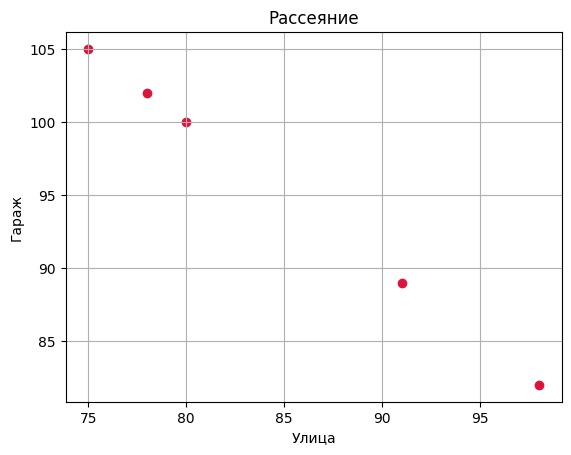

In [ ]:
plt.grid(True)
plt.title('Рассеяние')
plt.xlabel('Улица')
plt.ylabel('Гараж')
plt.scatter(x, y, marker = 'o', color = 'crimson')

## Задание 2
Найти и выгрузить данные. Вывести, провести предобработку и описать признаки.

In [ ]:
url = "https://raw.githubusercontent.com/N1ki0-0/dataPy/master/data/ECDCCases.csv"
data = pd.read_csv(url)

### Задание 2.1
Построить корреляционную матрицу по одной целевой переменной. Определить наиболее коррелирующую переменную, продолжить с ней работу в следующем пункте.

In [ ]:
data_numeric = data.select_dtypes(include=['number'])
if 'cases' in data_numeric.columns:
    target_variable = 'cases'
else:
    raise ValueError("Целевая переменная 'cases' не найдена среди числовых данных")
correlation_matrix = data_numeric.corr()
correlations = correlation_matrix[target_variable].drop(target_variable)
most_correlated_variable = correlations.abs().idxmax()
max_correlation = correlations[most_correlated_variable]

print("Корреляционная матрица:")
print(correlation_matrix)
print(f"Наиболее коррелирующая переменная с '{target_variable}': {most_correlated_variable}, коэффициент корреляции: {max_correlation}")


Корреляционная матрица:
                                                         day     month  \
day                                                 1.000000 -0.109528   
month                                              -0.109528  1.000000   
year                                               -0.057224 -0.054953   
cases                                              -0.004046  0.118788   
deaths                                             -0.006635  0.068337   
popData2019                                        -0.002860 -0.049889   
Cumulative_number_for_14_days_of_COVID-19_cases... -0.014147  0.310695   

                                                        year     cases  \
day                                                -0.057224 -0.004046   
month                                              -0.054953  0.118788   
year                                                1.000000  0.005607   
cases                                               0.005607  1.000000   
deaths       

### Задание 2.2
Реализовать регрессию вручную, отобразить наклон, сдвиг и MSE.

In [ ]:
x = data['deaths']
y = data['cases']
x_mean = np.mean(x)
y_mean = np.mean(y)
numerator = np.sum((x - x_mean) * (y - y_mean))
denominator = np.sum((x - x_mean) ** 2)
m = numerator / denominator
b = y_mean - m * x_mean
y_pred = m * x + b
mse = np.mean((y - y_pred) ** 2)
print(f"Наклон (m): {m}")
print(f"Сдвиг (b): {b}")
print(f"MSE: {mse}")

Наклон (m): 38.41170662842136
Сдвиг (b): 154.30092742273712
MSE: 20548041.80253447


### Задание 2.3
Визуализировать регрессию на графике.

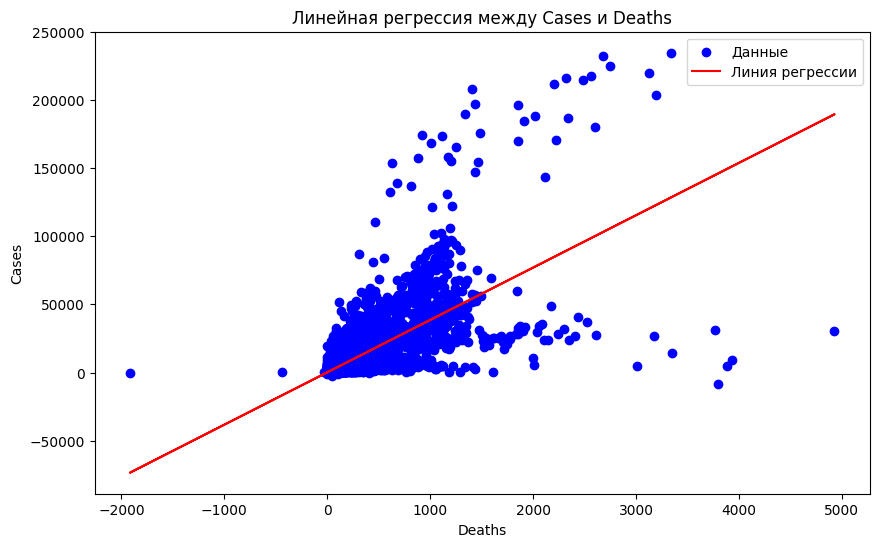

In [ ]:
x = data['deaths']
y = data['cases']

x_mean = np.mean(x)
y_mean = np.mean(y)
m = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)
b = y_mean - m * x_mean

y_pred = m * x + b

plt.figure(figsize=(10, 6))
plt.scatter(x, y, color="blue", label="Данные")
plt.plot(x, y_pred, color="red", label="Линия регрессии")
plt.xlabel("Deaths")
plt.ylabel("Cases")
plt.title("Линейная регрессия между Cases и Deaths")
plt.legend()
plt.show()

## Задание 3
Загрузить данные: 'insurance.csv'. Вывести и провести предобработку. Вывести список уникальных регионов.

In [ ]:
url = 'https://raw.githubusercontent.com/N1ki0-0/dataPy/master/data/insurance.csv'
data = pd.read_csv(url)

### Задание 3.1
Выполнить однофакторный ANOVA тест, чтобы проверить влияние региона на индекс массы тела (BMI), используя первый способ, через библиотеку Scipy.

In [5]:
region_groups = [data[data['region'] == region]['bmi'] for region in data['region'].unique()]
anova_result = stats.f_oneway(*region_groups)
print(anova_result)

F_onewayResult(statistic=39.49505720170283, pvalue=1.881838913929143e-24)


### Задание 3.2
Выполнить однофакторный ANOVA тест, чтобы проверить влияние региона на индекс массы тела (BMI), используя второй способ, с помощью функции anova_lm() из библиотеки statsmodels.

In [6]:
model = ols('bmi ~ C(region)', data=data).fit()
anova_results = anova_lm(model)
print(anova_results)

               df        sum_sq      mean_sq          F        PR(>F)
C(region)     3.0   4055.880631  1351.960210  39.495057  1.881839e-24
Residual   1334.0  45664.319755    34.231124        NaN           NaN


### Задание 3.3
С помощью t критерия Стьюдента перебрать все пары. Определить поправку Бонферрони. Сделать выводы.

In [7]:
regions = data['region'].unique()
region_pairs = list(combinations(regions, 2))
alpha = 0.05
k = len(region_pairs)
alpha_bonferroni = alpha / k
for region1, region2 in region_pairs:
    group1 = data[data['region'] == region1]['bmi']
    group2 = data[data['region'] == region2]['bmi']
    t_stat, p_value = stats.ttest_ind(group1, group2)
    print(f"Сравнение регионов: {region1} и {region2}")
    print(f"t-статистика: {t_stat:.4f}, p-значение: {p_value:.4f}")
    if p_value < alpha_bonferroni:
        print(f"Результат значим при уровне значимости {alpha_bonferroni:.4f} (с поправкой Бонферрони)")
    else:
        print(f"Результат незначим при уровне значимости {alpha_bonferroni:.4f} (с поправкой Бонферрони)")
    print("-" * 50)

Сравнение регионов: southwest и southeast
t-статистика: -5.9084, p-значение: 0.0000
Результат значим при уровне значимости 0.0083 (с поправкой Бонферрони)
--------------------------------------------------
Сравнение регионов: southwest и northwest
t-статистика: 3.2844, p-значение: 0.0011
Результат значим при уровне значимости 0.0083 (с поправкой Бонферрони)
--------------------------------------------------
Сравнение регионов: southwest и northeast
t-статистика: 3.1169, p-значение: 0.0019
Результат значим при уровне значимости 0.0083 (с поправкой Бонферрони)
--------------------------------------------------
Сравнение регионов: southeast и northwest
t-статистика: 9.2565, p-значение: 0.0000
Результат значим при уровне значимости 0.0083 (с поправкой Бонферрони)
--------------------------------------------------
Сравнение регионов: southeast и northeast
t-статистика: 8.7909, p-значение: 0.0000
Результат значим при уровне значимости 0.0083 (с поправкой Бонферрони)
-------------------------

### Задание 3.4
Выполнить пост-хок тесты Тьюки и построить график.

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
northeast northwest   0.0263 0.9999 -1.1552  1.2078  False
northeast southeast   4.1825    0.0   3.033   5.332   True
northeast southwest   1.4231 0.0107  0.2416  2.6046   True
northwest southeast   4.1562    0.0  3.0077  5.3047   True
northwest southwest   1.3968 0.0127  0.2162  2.5774   True
southeast southwest  -2.7594    0.0 -3.9079 -1.6108   True
----------------------------------------------------------


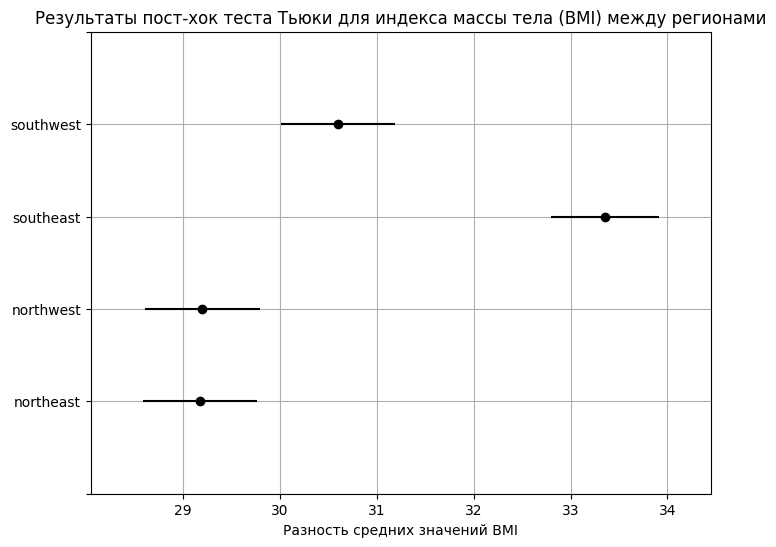

In [8]:
tukey = pairwise_tukeyhsd(endog=data['bmi'], groups=data['region'], alpha=0.05)
print(tukey)
fig = tukey.plot_simultaneous(figsize=(8, 6))
plt.title("Результаты пост-хок теста Тьюки для индекса массы тела (BMI) между регионами")
plt.xlabel("Разность средних значений BMI")
plt.grid(True)
plt.show()

### Задание 3.5
Выполнить двухфакторный ANOVA тест, чтобы проверить влияние региона и пола на индекс массы тела (BMI), используя функцию anova_lm() из библиотеки statsmodels.

In [9]:
print(data.isnull().sum())
data['region'] = data['region'].astype('category')
data['sex'] = data['sex'].astype('category')
formula = 'bmi ~ C(region) + C(sex) + C(region):C(sex)'
model = ols(formula, data=data).fit()
anova_results = anova_lm(model, typ=2)
print(anova_results)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
                        sum_sq      df          F        PR(>F)
C(region)          4034.975135     3.0  39.398134  2.163195e-24
C(sex)               86.007035     1.0   2.519359  1.126940e-01
C(region):C(sex)    174.157808     3.0   1.700504  1.650655e-01
Residual          45404.154911  1330.0        NaN           NaN


### Задание 3.6
Выполнить пост-хок тесты Тьюки и построить график.

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
northeastfemale   northeastmale  -0.2998 0.9998 -2.2706  1.6711  False
northeastfemale northwestfemale  -0.0464    1.0 -2.0142  1.9215  False
northeastfemale   northwestmale  -0.2042    1.0 -2.1811  1.7728  False
northeastfemale southeastfemale   3.3469    0.0    1.41  5.2839   True
northeastfemale   southeastmale   4.6657    0.0  2.7634   6.568   True
northeastfemale southwestfemale   0.7362 0.9497 -1.2377    2.71  False
northeastfemale   southwestmale   1.8051 0.1007 -0.1657   3.776  False
  northeastmale northwestfemale   0.2534 0.9999 -1.7083  2.2152  False
  northeastmale   northwestmale   0.0956    1.0 -1.8752  2.0665  False
  northeastmale southeastfemale   3.6467    0.0  1.7159  5.5775   True
  northeastmale   southeastmale   4.9655    0.0  3.0695  6.8614   True
  nort

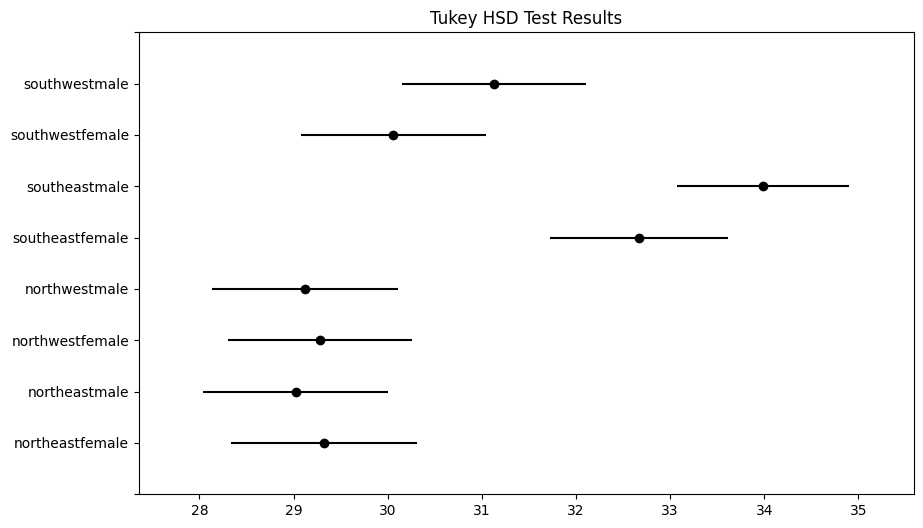

In [10]:
tukey = pairwise_tukeyhsd(endog=data['bmi'], groups=data['region'].astype(str) + data['sex'].astype(str), alpha=0.05)
print(tukey)
tukey.plot_simultaneous()
plt.title('Tukey HSD Test Results')
plt.show()